In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

## Discriminator

The discriminator for our GAN is going to be based off the architecture in the paper "Machine Learning Seismic Wave Discrimination: Application to Earthquake Early Warning" by Zefeng Li et al. In the paper, Li et al describe a discriminator that uses a stack of 1D convolutional layers and one fully connected layer to learn the features of p-waves. 
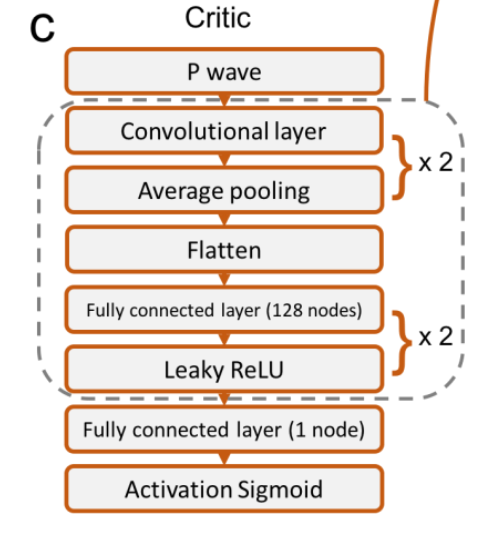

In [41]:
import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolution layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
        # Fully connected layer
        self.fc1 = nn.Linear(16 * 37, 128)
        # Output layer
        self.f2 = nn.Linear(128, 1)
        
        self.avgpool = nn.AvgPool1d(kernel_size=2, stride=2)
        # Dropout for training. Set model to evaluation mode to turn off. 
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Input size has three dimensions - [batch_size, channels, time]
        x = x.view(x.shape[0], 1, -1)
        x = self.conv1(x)
        x = self.avgpool(x)
        x = self.conv2(x)
        x = self.avgpool(x)
        # Reshape (flatten) tensor to pass through fully 
        # connected layer
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = torch.sigmoid(self.out(x))
        
        return x

critic = Discriminator()
critic

Discriminator(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(2,))
  (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(2,))
  (fc1): Linear(in_features=592, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
  (avgpool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (dropout): Dropout(p=0.2)
)

In [40]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 400)
        
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.dropout(F.leaky_relu(self.fc2(x)))
        x = F.tanh(self.fc3(x))
        
        return x
    
gen = Generator()
gen

Generator(
  (fc1): Linear(in_features=50, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=400, bias=True)
  (dropout): Dropout(p=0.3)
)

In [6]:
import h5py

data = h5py.File("../test/scsn_p_2000_2017_6sec_0.5r_pick_test.hdf5")

In [32]:
from torch.utils.data import DataLoader

# Load test data
dataset = data["X"]
testloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [18]:
model = Discriminator()

In [28]:
# Set model to evaluation mode and forward data through model
model.eval()
batch = next(iter(testloader))
model.forward(batch)

tensor([[0.4735],
        [0.4736],
        [0.4721],
        [0.4741],
        [0.4717],
        [0.4739],
        [0.4707],
        [0.4722],
        [0.4674],
        [0.4725],
        [0.4704],
        [0.4699],
        [0.4760],
        [0.4724],
        [0.4689],
        [0.4709],
        [0.4756],
        [0.4678],
        [0.4706],
        [0.4712],
        [0.4750],
        [0.4719],
        [0.4727],
        [0.4714],
        [0.4719],
        [0.4735],
        [0.4713],
        [0.4728],
        [0.4705],
        [0.4710],
        [0.4719],
        [0.4648]], grad_fn=<SigmoidBackward>)

In [29]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()